In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of rows and columns
num_rows = 100

num_columns = 2

# Create a DataFrame with random data
random_data = pd.DataFrame(np.random.rand(num_rows, num_columns), 
                            columns=[f'Column_{i+1}' for i in range(num_columns)])

print(random_data)

rd = random_data

x = 'Column_1'
y = 'Column_2'


rd[y] = round(rd[y])

for row in range(num_rows):
    if rd[y][row] == 1:
        rd[x][row] = rd[x][row] + 0.25 * 0.75
    else:
        rd[x][row] = rd[x][row] * 0.5
num_rows = num_rows // 2

x_train = rd[x][:num_rows]
y_train = rd[y][:num_rows]
x_test = rd[x][num_rows:]
y_test = rd[y][num_rows:]


'''
Column3 = 'Column_3'
Column4 = 'Column_4'
'''



'''
rd[Column3] = (rd[Column3]) + rd.index * np.tan(rd[Column3]) + rd.index
rd[Column4] = (rd[Column4]) + rd.index * np.arctan(rd[Column4]) + rd.index
'''

print(rd)
print(x_train, y_train)
print(x_test, y_test)

    Column_1  Column_2
0   0.548814  0.715189
1   0.602763  0.544883
2   0.423655  0.645894
3   0.437587  0.891773
4   0.963663  0.383442
..       ...       ...
95  0.398221  0.209844
96  0.186193  0.944372
97  0.739551  0.490459
98  0.227415  0.254356
99  0.058029  0.434417

[100 rows x 2 columns]
    Column_1  Column_2
0   0.736314       1.0
1   0.790263       1.0
2   0.611155       1.0
3   0.625087       1.0
4   0.481831       0.0
..       ...       ...
95  0.199111       0.0
96  0.373693       1.0
97  0.369775       0.0
98  0.113707       0.0
99  0.029015       0.0

[100 rows x 2 columns]
0     0.736314
1     0.790263
2     0.611155
3     0.625087
4     0.481831
5     0.979225
6     0.755545
7     0.035518
8     0.207718
9     0.965657
10    1.166118
11    0.648979
12    0.305774
13    0.330853
14    0.260924
15    0.452056
16    0.643650
17    0.206290
18    0.799596
19    1.131248
20    0.179754
21    0.348816
22    0.854267
23    0.105191
24    0.157714
25    0.285098
26    0.49

/var/folders/bt/3390lzb90_s2rvpsqfx38rwc0000gp/T/ipykernel_42730/23495191.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  rd[x][row] = rd[x][row] + 0.25 * 0.75
/var/folders/bt/3390lzb90_s2rvpsqfx38rwc0000gp/T/ipykernel_42730/23495191.py

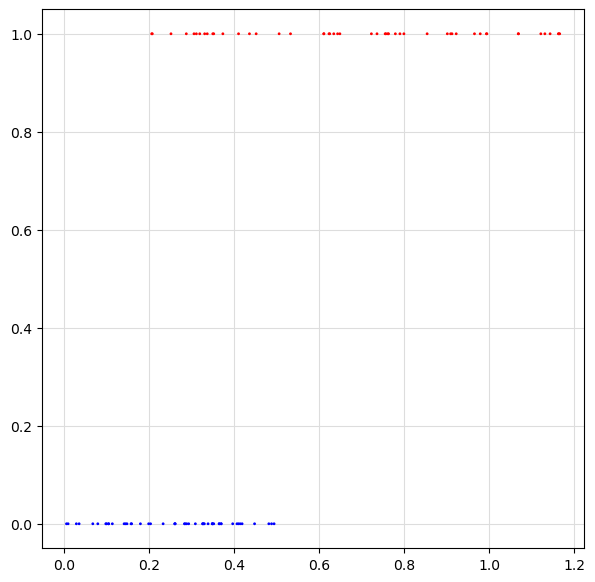

In [155]:
size = 1000 / num_rows
plt.figure(figsize=(7, 7))
threshold = 0.5

colors = np.where(rd[y] < threshold, 'blue', 'red')
plt.scatter(rd[x], rd[y], c=colors, s=1, zorder=2)

plt.grid(which='major', color='#DDDDDD', linewidth=0.8, zorder=1)

plt.show()

In [156]:
def init_slope_and_intercept(dataset):
    B0 = 0
    B1 = 0
    B = 0.0000001
    B0_list = []
    B1_list = []
    for row in range(num_rows):
        B0_list.append(0)
        B1_list.append(0)
    return B0, B1, B0_list, B1_list, B

B0, B1, B0_list, B1_list, B = init_slope_and_intercept(rd)
print(B0, B1, B0_list, B1_list)

0 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [157]:
def sigmoid(num, bias, weight):
    z = bias + weight * num
    ai = 1 / (1 + (np.e ** (-z)))

    epsilon = 1e-15
    predictions = np.clip(ai, epsilon, 1 - epsilon)
    return predictions

In [158]:
def calc_error(bias, weight, samples, dataset):
    
    n = samples
    error_sum = 0
    
    sum_dl_dw = 0
    sum_dl_db = 0
    
    for row in range(n):
        xi = x_train[row]
        yi = y_train[row]
        
        ai = sigmoid(xi, bias, weight)
        
        dl_dw = (ai - yi) * xi
        dl_db = ai - yi
        
        sum_dl_dw += dl_dw
        sum_dl_db += dl_db
        
        error_sum += yi * np.log(ai) + (1 - yi) * np.log(1 - ai)

    avg_dl_dw = sum_dl_dw / n
    avg_dl_db = sum_dl_db / n
    log_loss = error_sum / n
    
    return log_loss, avg_dl_dw, avg_dl_db
log_loss, avg_dl_dw, avg_dl_db = calc_error(B0, B1, num_rows, rd)
print(log_loss, avg_dl_dw, avg_dl_db)

-0.6931471805599446 -0.08162244596056553 0.04


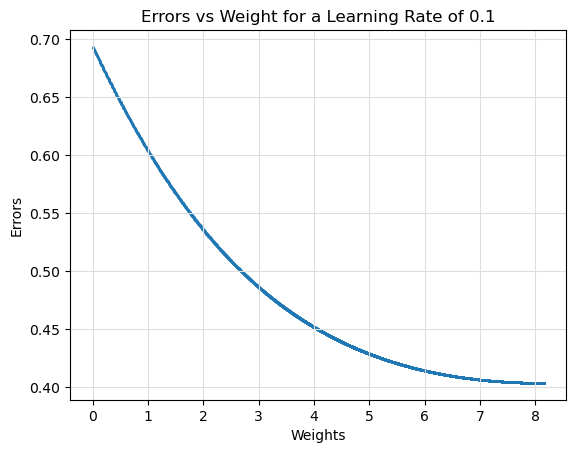

-3.5440139860016546 8.154645047795519 14741


In [159]:
def gradient_descent_of_parameters(learning_rate, max_iterations, min_step_size, bias, weight, samples, dataset):

    step_size = 1
    iteration = 0
    error_list = []
    bias_list = []
    weight_list = []
    while (iteration < max_iterations):

        log_loss, avg_dl_dw, avg_dl_db = calc_error(bias, weight, samples, dataset)
        error_list.append(log_loss)
        weight_list.append(weight)
        bias_list.append(bias)
        weight = weight - (learning_rate * avg_dl_dw)
        bias = bias - (learning_rate * avg_dl_db)
        step_size = max(abs(learning_rate * avg_dl_dw), abs(learning_rate * avg_dl_db))
        iteration += 1

        if step_size < min_step_size:
            break
            
    abs_error_list = [abs(value) for value in error_list]
    
    return bias, weight, iteration, error_list, weight_list, bias_list, abs_error_list

lr = 0.1
max_iteration = 50000
min_step_size = 0.00001
B0, B1, iteration, error_list, weight_list, bias_list, abs_error_list = gradient_descent_of_parameters(lr, max_iteration, min_step_size, B0, B1, num_rows, rd)

plt.scatter(weight_list, abs_error_list, s=1)    
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.title(f'Errors vs Weight for a Learning Rate of {lr}')
plt.xlabel('Weights')
plt.ylabel('Errors')
plt.show()

print(B0, B1, iteration)

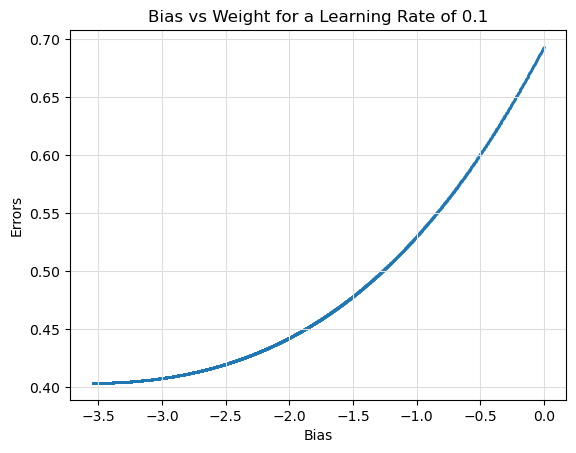

In [160]:
plt.scatter(bias_list, abs_error_list, s=1)    
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.title(f'Bias vs Weight for a Learning Rate of {lr}')
plt.xlabel('Bias')
plt.ylabel('Errors')
plt.show()

In [161]:
def test_accuracy(x_values, y_values, bias, weight, samples):
    
    correct_estimates = 0
    p_list = []
    for row in range(samples):
        xi = x_values[row+samples]
        yi = y_values[row+samples]
        
        p = sigmoid(xi, bias, weight)
        p_list.append(p)

        predicted_class = 1 if p >= 0.5 else 0
        
        if predicted_class == yi:
            correct_estimates += 1
            
    acc = (correct_estimates / samples) * 100

    return acc, p_list

# Example usage
acc, p_list = test_accuracy(x_test, y_test, B0, B1, num_rows)
print(f'Model Accuracy: {acc:.2f}%')

Model Accuracy: 84.00%


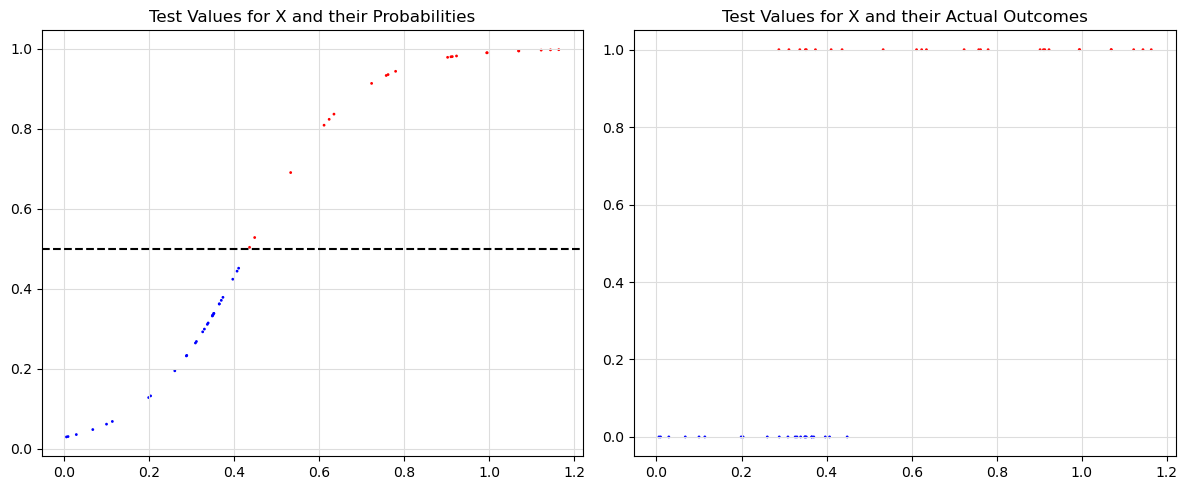

In [162]:
p_array = np.array(p_list)
colors = np.where(p_array < threshold, 'blue', 'red')    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_test, p_list, s=1, color=colors)   
ax1.set_title('Test Values for X and their Probabilities')
ax1.axhline(y=0.5, color='black', linestyle='--')
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)

colors = np.where(y_test < threshold, 'blue', 'red')    

ax2.scatter(x_test, y_test, s=1, color=colors)   
ax2.set_title('Test Values for X and their Actual Outcomes')

ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.tight_layout()

plt.show()